<a href="https://colab.research.google.com/github/cskate1997/Computervision_with_Tensorflow/blob/main/Final__DeepLearningScreenTurtleChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

*In this challenge you will be asked to build a deep learning solution capable of segmenting turtles on synthetic images. You will be provided with the data, which you can use to train your models; your best model will be used on a test image and you will be asked to implement some geometric algorithms based on the predictions of your model.*

***Training data***

The training data will consist of 30 256x256 images of the same synthetic turtle pasted on background images artificially generated by BigGAN (https://arxiv.org/abs/1809.11096).

Feel free to increase the dataset size as needed and make any relevant changes to the dataset creation. 

Each image will come with the ground truth per-pixel segmentation mask which you can leverage for your training setup. We strongly recommend that you treat the provided task as semantic segmentation with 2 classes -- foreground (turtle) and background (everything else).

You are also allowed to use external data sources and pre-trained weights, but please provide justification if you choose to do so.


***Test data***

There will only be a single test image without the provided GT.

The test image differs from the training data and it is up to you to decide how to approach these differences. Notably, the test image is of resolution 512x512 and your predicted mask must be of the same resolution.


***Tasks***

1. Your main task is to build a deep learning model capable of accurately segmenting the turtle in the test image.
2. Based on the segmentation mask predicted by your model, you will need to implement an algorithm that finds a convex hull, i.e. a polygon enclosing all the foreground (i.e. turtle) pixels.
3. [Bonus Points] Implement an algorithm that calculates the area of the polygon from the result of task 2. 

***If you are using third-party code, you have to provide explanation of why you need that code and what that code does. We evaluate your submission based on the code you have written and if there is no such code, we won't be able to evaluate and proceed to the next stage.***

***Rules***

* While we provide all the code in PyTorch, feel free to use other deep learning frameworks as needed
* Feel free to use all the imported Python libraries
* For tasks 2 and 3 ***you are not allowed*** to use third-party functions that readily solve those tasks, e.g. you are not allowed to use various `cv2` and `scikit-image` operators. We expect the algorithms to be based on points and geometry rather than full-image operations.


***Submission***

* ***You must send us only a single link to the Colab notebook with your solution and nothing else!*** We should be able to reproduce your results by running the notebook. If you require additional files, use `gdown` to download them into the session storage (see Task 1 for details).
* Include your comments and explanations on the decisions that you made to approach the problem;
* Make sure to include the estimate of approximately how much time it took you to get to the final solution.

***Colab setup***

* To use GPU, go to `Runtime -> Change Runtime Type -> GPU`

In [14]:
pip install pytorch_pretrained_biggan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 10.4 MB/s 
     |████████████████████████████████| 9.0 MB 54.1 MB/s 
     |████████████████████████████████| 79 kB 11.1 MB/s 
     |████████████████████████████████| 139 kB 76.7 MB/s 
     |████████████████████████████████| 127 kB 76.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
# comment the following line if you are working outside of a notebook environment
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [2]:
# Used to download any files you need for your solution from Google Drive
import gdown
gdown.download("https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML", "turtle.png", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML
To: /content/turtle.png
100%|██████████| 692k/692k [00:00<00:00, 78.2MB/s]


'turtle.png'

In [3]:
# read and visualise the turtle image
turtle_image = Image.open('./turtle.png')
# it is a 4-channel RGB+Alpha image of size 2394x1800
print(turtle_image.mode, turtle_image.size)

RGBA (2394, 1800)


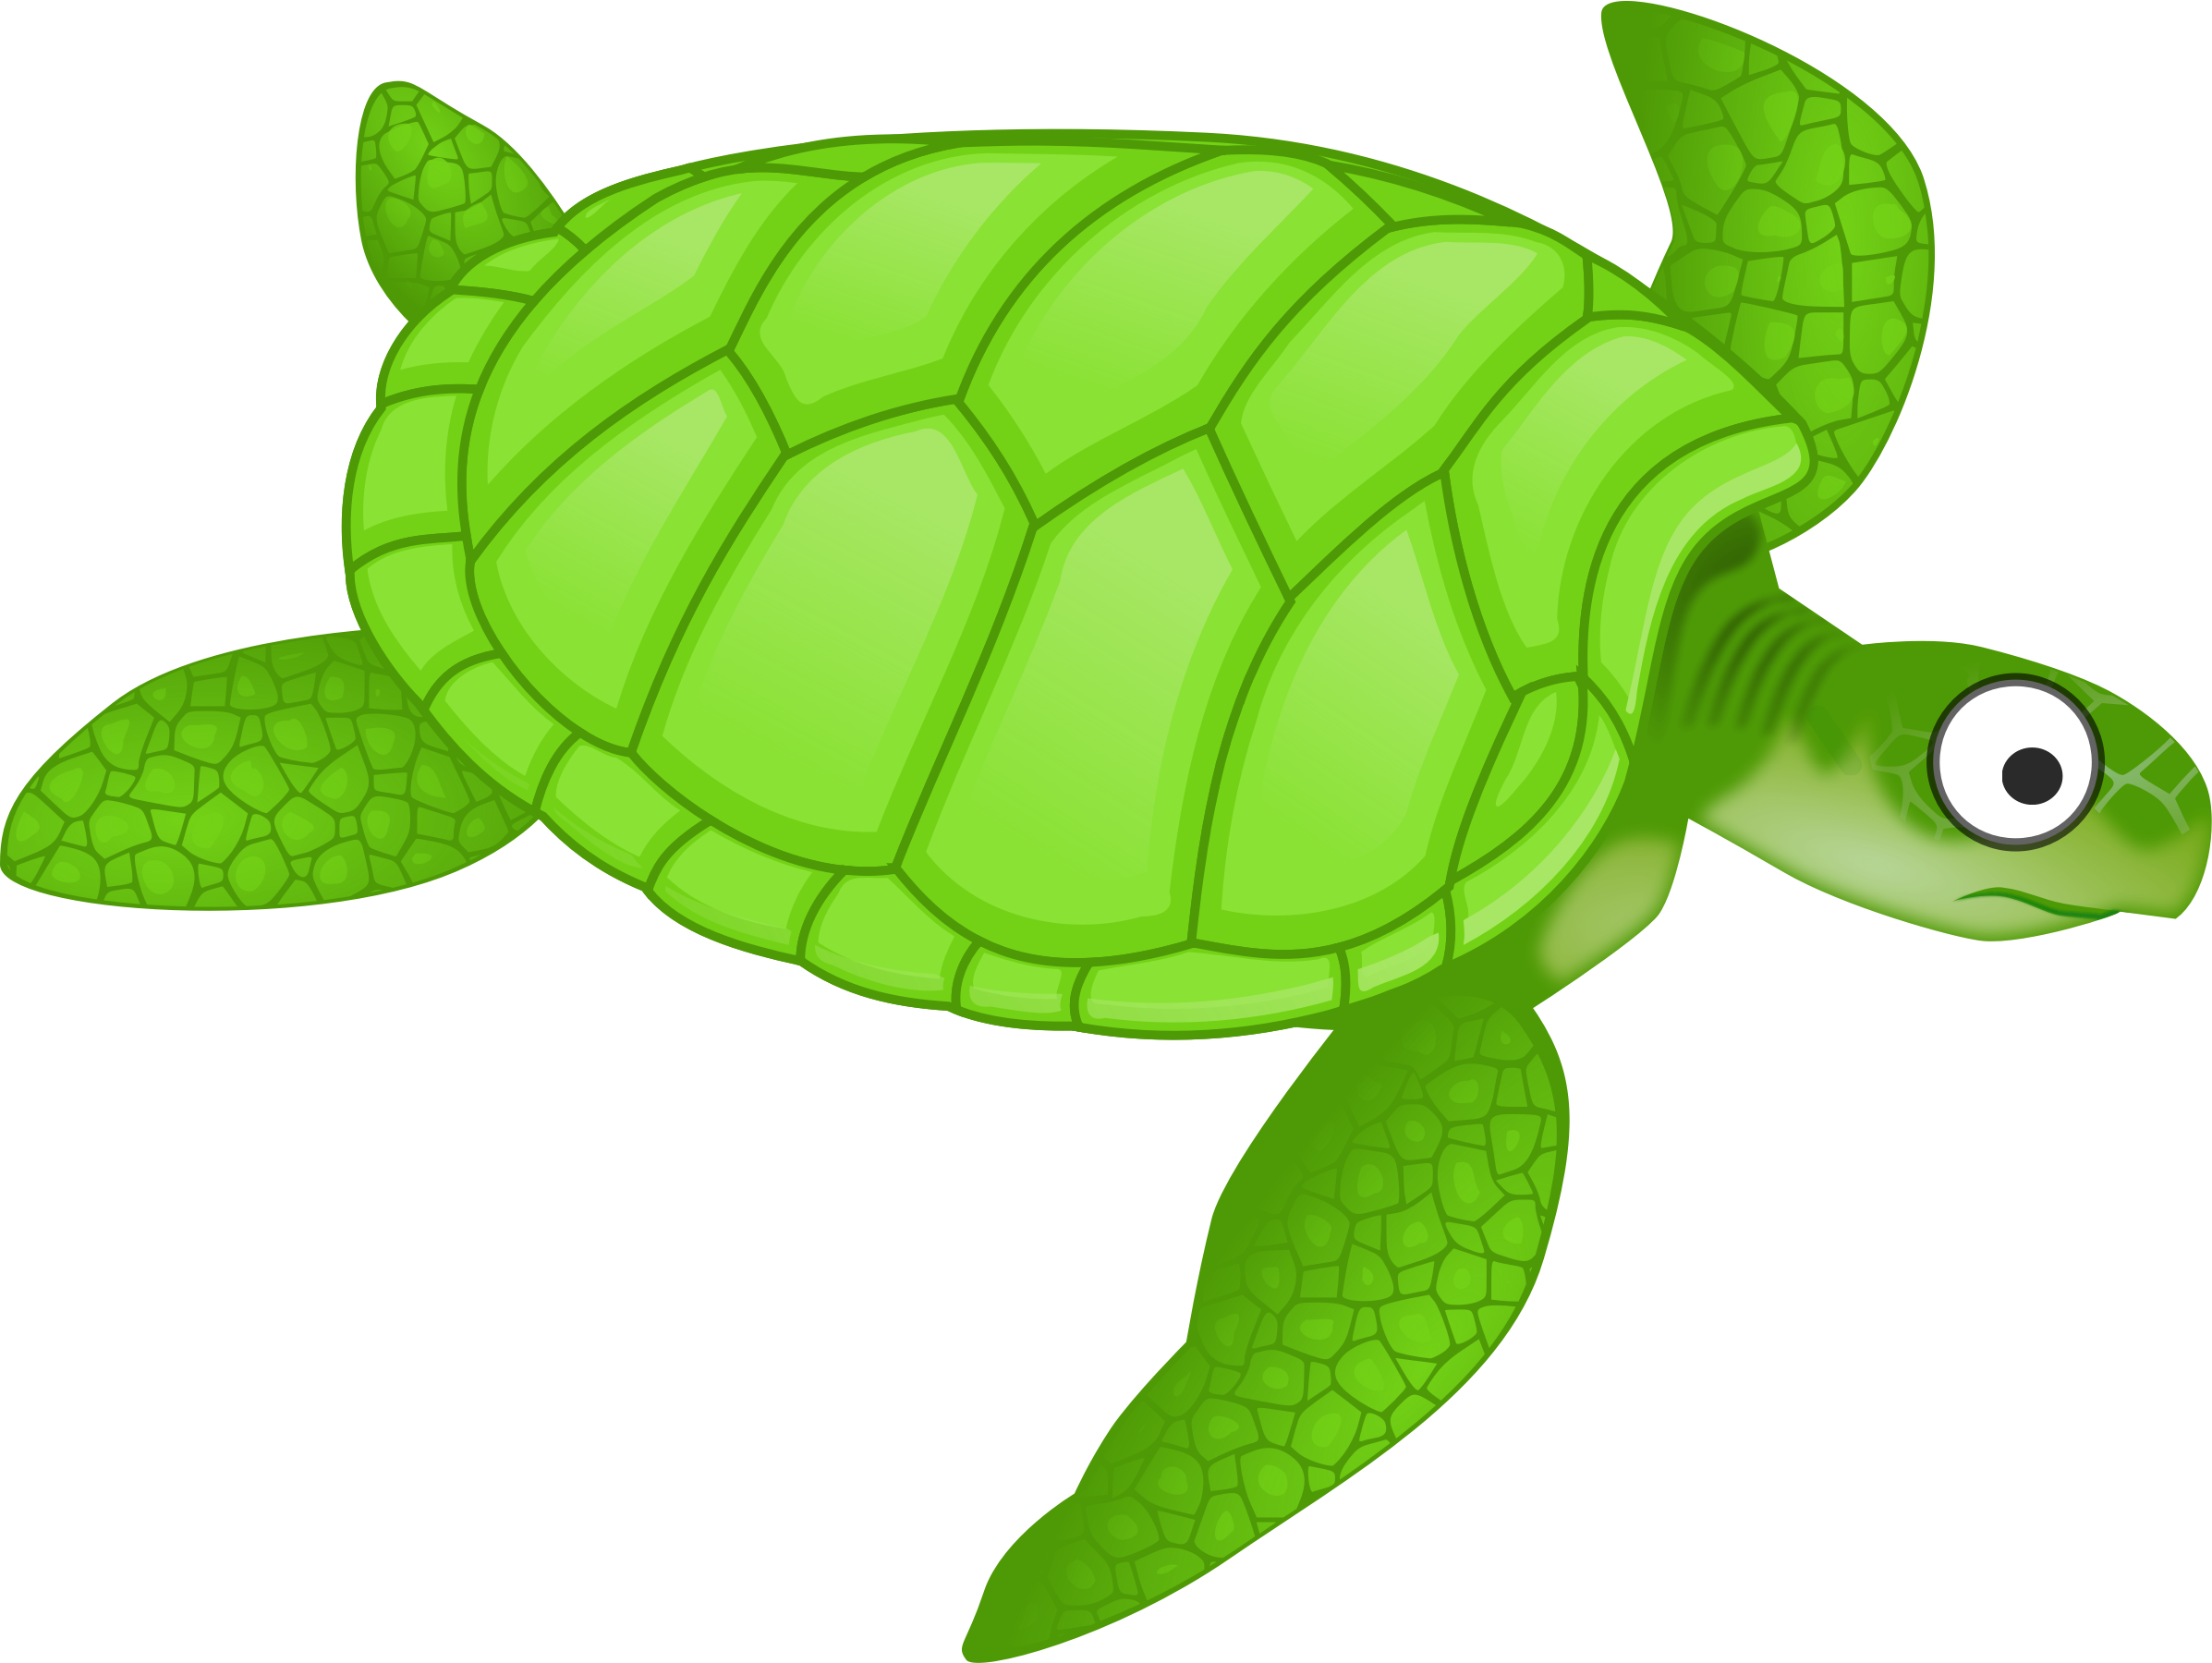

In [4]:
turtle_image

In [5]:
# to create the training set, we will resize the turtle image to 256x256
turtle_image_256x256 = turtle_image.resize((256, 256))

# Background Images

As written above, we will use a generative adversarial network called "BigGAN" pre-trained on ImageNet to create a set of background images 

In [7]:
# first, we need to install the python package called `pytorch_pretrained_biggan` (https://github.com/huggingface/pytorch-pretrained-BigGAN)
# if in the notebook environment, please uncomment the following line to install this package
# !pip install pytorch_pretrained_biggan
# there might be some errors related to pip's dependency resolver which you can safely ignore

In [6]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN,
    truncated_noise_sample,
    convert_to_images,
    one_hot_from_int,
)

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# boilerplate pytorch code enforcing reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

BigGAN is a memory-intensive network.

To save time and memory, we will only generate 30 different background images.
Feel free to change this setup as needed.

In [8]:
# load the 256x256 model
model = BigGAN.from_pretrained('biggan-deep-256').to(device).eval()

# every time we will run with batch size of 3 in order to not run out of memory
num_passes = 10
batch_size = 3

# default noise value from the provided repository
truncation = 0.4

background_images = []

for _ in range(num_passes):
    # BigGAN uses imagenet and hence each time we will choose one of 1000 categories
    class_vector = torch.from_numpy(
        one_hot_from_int(np.random.randint(0, 1000, size=batch_size), batch_size=batch_size)
    ).to(device)
    noise_vector = torch.from_numpy(
        truncated_noise_sample(truncation=truncation, batch_size=batch_size)
    ).to(device)

    # Generate the images and convert them to PIL image
    with torch.no_grad():
        output = model(noise_vector, class_vector, truncation).cpu()
        background_images.extend(convert_to_images(output))

# We won't need the GAN model anymore,
# so we can safely delete it and free up some memory
del model
torch.cuda.empty_cache()

100%|██████████| 715/715 [00:00<00:00, 442580.78B/s]


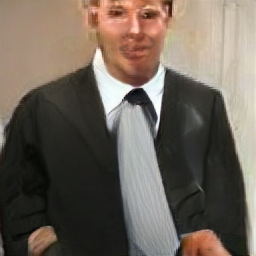

In [9]:
# Let's see how one of the images look like
random.choice(background_images)

# Training Set
Given 30 background images and the turtle image, we will paste the turtle onto the background images.

In [10]:
import torchvision
import torchvision.transforms as transforms

In [11]:
tensor_transform = transforms.ToTensor()

def random_paste(background_image, turtle_image, min_scale=0.25, max_scale=0.65):
    """Randomly scales and pastes the turtle image onto the background image"""
    
    w, h = turtle_image.size
    # first, we will randomly downscale the turtle image
    new_w = int(random.uniform(min_scale, max_scale) * w)
    new_h = int(random.uniform(min_scale, max_scale) * h)
    resized_turtle_image = turtle_image.resize((new_w, new_h))

    # second, will randomly choose the locations where to paste the new image
    start_w = random.randint(0, w - new_w)
    start_h = random.randint(0, h - new_h)

    # third, will create the blank canvas of the same size as the original image
    canvas_image = Image.new('RGBA', (w, h))

    # and paste the resized turtle onto it, preserving the mask
    canvas_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)
    
    # Turtle image is of mode RGBA, while background image is of mode RGB;
    # `.paste` requires both of them to be of the same type.
    background_image = background_image.copy().convert('RGBA')
    # finally, will paste the resized turtle onto the background image
    background_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)
    return background_image, canvas_image

In [12]:
training_set = []  # image, segmentation mask

for background_image in background_images:
  # paste the turtle onto background image
  aug_image, aug_mask = random_paste(background_image.copy(), turtle_image_256x256.copy())
  # convert PIL images to pytorch tensors
  training_pair = [
      tensor_transform(aug_image)[:3],  # keep the rgb only
      # For the mask, we only need the last (4th) channel,
      # and we will encode the mask as boolean
      tensor_transform(aug_mask)[-1:] > 0,
  ]
  training_set.append(training_pair)

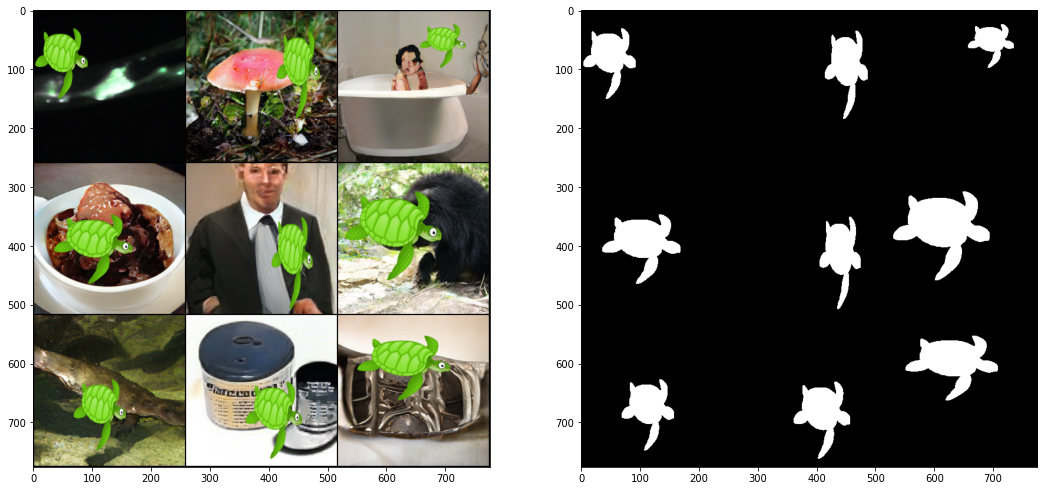

In [13]:
# Let's visualise some subset of the training set
sample_indices = np.random.choice(len(training_set), size=9, replace=False)
sample_images = []
sample_masks = []
for i in sample_indices:
    image, mask = training_set[i]
    sample_images.append(image)
    sample_masks.append(mask)
    
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_images, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_masks, nrow=3).permute(1, 2, 0).float().cpu().numpy())

# Test Image
Now, let's load the test image. As mentioned above, it is of a slightly higher 512x512 resolution.

In [ ]:
#Also load below Test image and it's dependencies during testing and polygon plotting

Downloading...
From: https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa
To: /content/test.png
100%|██████████| 413k/413k [00:00<00:00, 51.7MB/s]

RGB (512, 512)


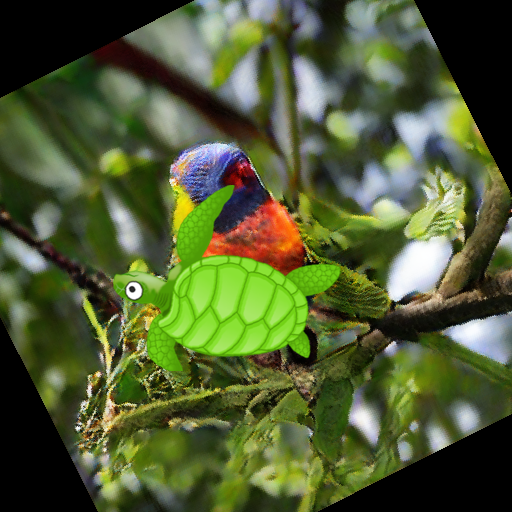

In [14]:
gdown.download("https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa", "test.png", quiet=False)
test_image = Image.open('./test.png')
# it is a 3-channel RGB image of size 512x512
print(test_image.mode, test_image.size)
test_image

# Task 1: Predicting segmentation mask

*This is where you need to implement your deep learning solution. Your approach should output a result at the native 512x512 resolution of the test image.* 

In [ ]:
# # TODO: Implement and train the deep model

# # TODO: Save the model weights and upload them to Google Drive

# load_model_weights = False
# if load_model_weights:
#     # After uploading your saved model weights to Google Drive, share to
#     # "Anyone with the link" and extract FILE_ID from the share link
#     # See https://support.google.com/drive/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop
#     # for more information
#     # Now the weights can be downloaded and used via gdown:
#     saved_model_url = "https://drive.google.com/uc?id=FILE_ID"
#     gdown.download(saved_model_url, "saved_model.pth", quiet=True)

#     # TODO: Load your saved model weights e.g. torch.load("saved_model.pth")

# test_image_tensor = tensor_transform(test_image)

# def get_mask_from_image(test_image):
#   # TODO: Use the deep model that predicts the segmentation mask on the test image
#   # The model with the saved weights should be used, if load_model_weights is True
#   test_mask = test_image.mean(0) < 0.5
#   return test_mask.byte()

# test_mask_tensor = get_mask_from_image(test_image_tensor)

# plt.figure(figsize=(12, 12))
# plt.subplot(121)
# plt.imshow(test_image_tensor.numpy().transpose(1, 2, 0))
# plt.subplot(122)
# plt.imshow(test_mask_tensor.numpy(), cmap="gray", vmin=0, vmax=1)

In [15]:
#Import the libraries for predicting
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf


Learning_Rate=1e-4
width=height=512 # image width and height
batchSize=3

In [16]:
#Transforms

transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)), tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)), tf.ToTensor()])

In [17]:
from PIL import Image, ImageOps
import torchvision.transforms as T
from torchvision.utils import save_image
import numpy as np
import cv2

#Convert image and mask to it's format
def ReadRandomImage():
  indx=np.random.randint(0,len(training_set))
  Img, mask = training_set[indx]
  mask = mask.bool().int()
  mask = mask.cpu().detach().numpy()
  mask = mask.transpose((1,2,0)).squeeze()
  Img = Img.cpu().detach().numpy()
  Img = Img.transpose((1,2,0))
  Img = Img.astype(np.float64) / Img.max()
  Img = 255 * Img
  img = Img.astype(np.uint8)
  # msk = T.ToPILImage()(mask.to('cpu'))
  # # gray_image = ImageOps.grayscale(msk)
  # im1 = msk.save("gk.png", format= "PNG")
  AnnMap = np.zeros(img.shape[0:2], np.float32)
  if mask is not None: AnnMap[mask == 1] = 1
  Img = transformImg(img)
  AnnMap = transformAnn(AnnMap)

  return Img, AnnMap

In [18]:
def LoadBatch(): # Load batch of images
    images = torch.zeros([batchSize,3,height,width])
    ann = torch.zeros([batchSize, height, width])
    
    for i in range(batchSize):
        images[i],ann[i]=ReadRandomImage()
    
    return images, ann

In [19]:
#Check if device can use GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#model
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
Net.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 2 classes
Net=Net.to(device)

#Optimizer
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

# **Training**



In [20]:
#Training

for itr in range(10002): # Training loop
   images,ann=LoadBatch() 
   
   images=torch.autograd.Variable(images,requires_grad=False).to(device)    
   
   ann = torch.autograd.Variable(ann,requires_grad=False).to(device)              
   
   Pred=Net(images)['out'] # make prediction
   Net.zero_grad()
   
   #Loss Function
   criterion = torch.nn.CrossEntropyLoss() # Set loss function
   Loss=criterion(Pred,ann.long()) # Calculate cross entropy loss
   Loss.backward() # Backpropogate loss
   optimizer.step() # Apply gradient descent change to weight
   seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get prediction classes
   print(itr,") Loss=",Loss.data.cpu().numpy())
   
   if itr % 500 == 0: #Save model weight once every 500 steps permenant file
        print("Saving Model :" +str(itr) + ".torch")
        torch.save(Net.state_dict(),   str(itr) + ".torch")

Streaming output truncated to the last 5000 lines.
5012 ) Loss= 0.003186199
5013 ) Loss= 0.0035193115
5014 ) Loss= 0.003531497
5015 ) Loss= 0.003599705
5016 ) Loss= 0.0037785722
5017 ) Loss= 0.0029960366
5018 ) Loss= 0.0031443601
5019 ) Loss= 0.0038186861
5020 ) Loss= 0.0033070336
5021 ) Loss= 0.0031238042
5022 ) Loss= 0.003455919
5023 ) Loss= 0.0034709936
5024 ) Loss= 0.0037883837
5025 ) Loss= 0.0034738851
5026 ) Loss= 0.0041039665
5027 ) Loss= 0.0032316565
5028 ) Loss= 0.0040194383
5029 ) Loss= 0.003502273
5030 ) Loss= 0.004132508
5031 ) Loss= 0.0035520562
5032 ) Loss= 0.0034297246
5033 ) Loss= 0.0029922866
5034 ) Loss= 0.00307526
5035 ) Loss= 0.0035987545
5036 ) Loss= 0.0033524456
5037 ) Loss= 0.0034494046
5038 ) Loss= 0.0036631783
5039 ) Loss= 0.0035396416
5040 ) Loss= 0.0035017736
5041 ) Loss= 0.0036754347
5042 ) Loss= 0.0036517298
5043 ) Loss= 0.0032811237
5044 ) Loss= 0.0032034602
5045 ) Loss= 0.0034527949
5046 ) Loss= 0.0031077426
5047 ) Loss= 0.0034533509
5048 ) Loss= 0.003933

**Download Saved model weights**

In [ ]:
#Download the model, Anyone have access with this link, if it dosen't work email me-katechinmay@gmail.com

In [ ]:
import gdown
# https://drive.google.com/file/d/16Ea8QLWmDSxVhYFidXXwMpqwTgrRBMgJ/view?usp=sharing

#From above link u can directly download the saved model if the below link dosen't works and upload in the 'Files' in the collab
saved_model_url = "https://drive.google.com/uc?id=7500.torch"
gdown.download(saved_model_url, "saved_model4_7500.torch", quiet=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


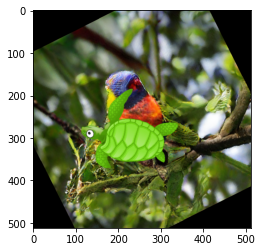

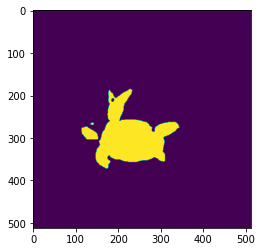

In [69]:
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt

modelPath = "7500.torch"  # Path to trained model, change the name respectively
imagePath = "./test.png"  # Test image
height=width=512

transformImg = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)), tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])  

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  

Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)  # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))  # Change final layer to 2 classes
Net = Net.to(device)  # Set net to GPU or CPU
Net.load_state_dict(torch.load(modelPath)) # Load trained model

#Evaluation
Net.eval() # Set to evaluation mode
Img = cv2.imread(imagePath) # load test image


height_orgin , widh_orgin ,d = Img.shape # Get image original size 
plt.imshow(Img[:,:,::-1])  # Show image
plt.show()
Img = transformImg(Img)  # Transform to pytorch
Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)
with torch.no_grad():
    Prd = Net(Img)['out']  # Run net
Prd = tf.Resize((height_orgin,widh_orgin))(Prd[0]) # Resize to origninal size
seg = torch.argmax(Prd, 0).cpu().detach().numpy()  # Get  prediction classes
plt.imshow(seg)  # display image
plt.show()

In [70]:
test_mask_tensor = tensor_transform(seg)
test_image_tensor = tensor_transform(test_image)

# Task 2: Calculating tight enclosing polygon from segmentation mask

*This is where you need to implement your algorithm that predicts a convex hull, an enclosing polygon of foreground pixels. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Treat this problem as point-based rather than the image-based one.*

*You don't have to use PyTorch for this part. Your approach should output a result at the native 512x512 resolution of the test image.* 

*For the purposes of this assignment, O(n^2) is considered a good time complexity*

In [71]:
from functools import cmp_to_key

class Pixel:
  def __init__(self, x = None, y = None):
    self.x = x
    self.y = y

pi0 = Pixel(0,0)

def sec_top(S):
  return S[-2]

def sqrdist(pi1,pi2):
  return ((pi1.x - pi2.x)*(pi1.x - pi2.x) + (pi1.y - pi2.y)*(pi1.y - pi2.y))

def orientation(p, q, r):
    val = ((q.y - p.y) * (r.x - q.x) -
           (q.x - p.x) * (r.y - q.y))
    if val == 0:
        return 0  # collinear
    elif val > 0:
        return 1  # clock wise
    else:
        return 2  # counterclock wise

def compare(pi1, pi2):
   
    # Find orientation
    o = orientation(pi0, pi1, pi2)
    if o == 0:
        if sqrdist(pi0, pi2) >= sqrdist(pi0, pi1):
            return -1
        else:
            return 1
    else:
        if o == 2:
            return -1
        else:
            return 1

def convexHull(points, n):
   
    ymin = points[0].y
    min = 0
    for i in range(1, n):
        y = points[i].y

        if ((y < ymin) or
            (ymin == y and points[i].x < points[min].x)):
            ymin = points[i].y
            min = i
 
    points[0], points[min] = points[min], points[0]
 
    p0 = points[0]
    points = sorted(points, key=cmp_to_key(compare))
 
    m = 1  
    for i in range(1, n):
        while ((i < n - 1) and
        (orientation(p0, points[i], points[i + 1]) == 0)):
            i += 1
 
        points[m] = points[i]
        m += 1  
    
    if m < 3:
        return

    S = []
    S.append(points[0])
    S.append(points[1])
    S.append(points[2])
    for i in range(3, m): 
        while ((len(S) > 1) and
        (orientation(sec_top(S), S[-1], points[i]) != 2)):
            S.pop()
        S.append(points[i])
    output = []
    while S:
        p = S[-1]
        output.append([p.x,p.y])
        S.pop()
    pts_ord = tensor_transform(np.asarray(output)).squeeze()
    return pts_ord

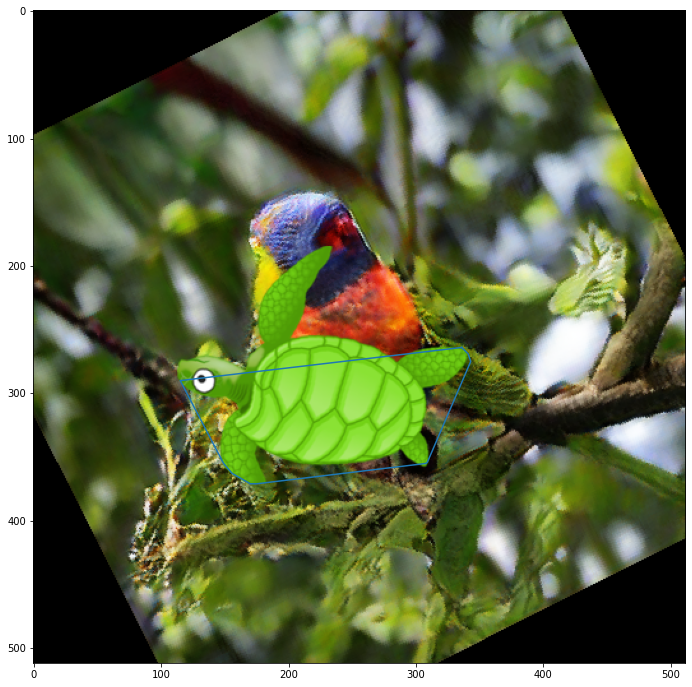

In [72]:
def get_tight_polygon_from_mask(test_mask):
  # TODO: Implement an algorithm that computes the enclosing polygon from the segmentation mask.
  mask_points_n2 = torch.stack(torch.where(test_mask_tensor == 1), 1)
  a = mask_points_n2.tolist()
  new_mask_points = []
  for i in a:
    new_mask_points.append(tuple(i[1:]))
  points = []
  for point in new_mask_points:
    points.append(Pixel(point[0],point[1]))

  n = len(points)
  polygon_points_n2 = convexHull(points,n)
  return polygon_points_n2

def visualize_polygon_on_image(test_image, polygon_points_n2):
  # append first point to close the figure
  polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
  ys, xs = torch.split(polygon_points_n2, 1, dim=-1)  
  plt.figure(figsize=(12, 12))
  plt.imshow(test_image.numpy().transpose(1, 2, 0))
  plt.plot(xs.numpy(), ys.numpy()) 


polygon_points_n2_tensor = get_tight_polygon_from_mask(test_mask_tensor)
visualize_polygon_on_image(test_image_tensor, polygon_points_n2_tensor)


# Task 3 [bonus points]: Calculating the area of the polygon
*This is where you need to implement your area calculation algorithm. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Once again, treat this problem as a point-based rather than the image-based one.*

*You don't have to use PyTorch for this part. Your approach should output a result at the native 512x512 resolution of the test image.* 

In [73]:
def calculate_polygon_area(polygon_points_n2):
  # TODO: Implement the algorithm
  area = 0.0

  polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
  ys, xs = torch.split(polygon_points_n2, 1, dim=-1)

  n = len(xs)

  j = n-1
  for i in range(0,n):
    area += (xs[j] + xs[i]) * (ys[j] - ys[i])
    j = i
  return int(abs(area/2.0))

print("Area = {:.4f}".format(calculate_polygon_area(polygon_points_n2_tensor)))

Area = 16704.0000
